In [2]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
%pip install -U albumentations


In [4]:
%pip install -U timm
%pip install open_clip_torch
%pip install torchviz
%pip install torchinfo
import open_clip
from transformers import BertModel, BertTokenizer
from torchviz import make_dot
from torchinfo import summary
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil
import kagglehub
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split,WeightedRandomSampler , Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import timm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.20
    Uninstalling timm-1.0.20:
      Successfully uninstalled timm-1.0.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00


In [5]:
path = kagglehub.dataset_download("salmansajid05/oral-diseases")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'oral-diseases' dataset.
Path to dataset files: /kaggle/input/oral-diseases


In [6]:
#Define original directories
original_dirs = {'Calculus': '/kaggle/input/oral-diseases/Calculus/Calculus',
               'Caries' : '/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview',
               'Gingivitis' : '/kaggle/input/oral-diseases/Gingivitis/Gingivitis',
               'Mouth Ulcer' : '/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
               'Tooth Discoloration' : '/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview',
               'hypodontia' : '/kaggle/input/oral-diseases/hypodontia/hypodontia'}

#Define target base directory
base_dir = "/kaggle/working/dataset"
splits = ['train','val','test']
classes = list(original_dirs.keys())

#Create target directories
for split in splits:
    for class_name in classes :
        os.makedirs(os.path.join(base_dir,split,class_name),exist_ok = True)

#Function to copy and split images
def copy_and_transfer_images(class_name ,image_paths):
    train_path , test_path = train_test_split(image_paths , test_size = 0.1, random_state =42 )
    train_path , val_path = train_test_split(train_path , test_size = 0.15, random_state =42 )
    split_path = {'train': train_path , 'val' : val_path , 'test' : test_path}

    for split, paths in split_path.items():
        for img_path in paths :
            target_path = os.path.join(base_dir , split , class_name , os.path.basename(img_path))
            shutil.copy(img_path, target_path)

#Organize dataset
for class_name , original_dir in original_dirs.items():
    image_paths = [os.path.join(root,file) for root, _ , files in os.walk(original_dir)
                   for file in files if file.endswith(('.jpeg','.jpg','.png'))]
    if image_paths:
        copy_and_transfer_images(class_name ,image_paths)

print("Images organized successfully.")

Images organized successfully.


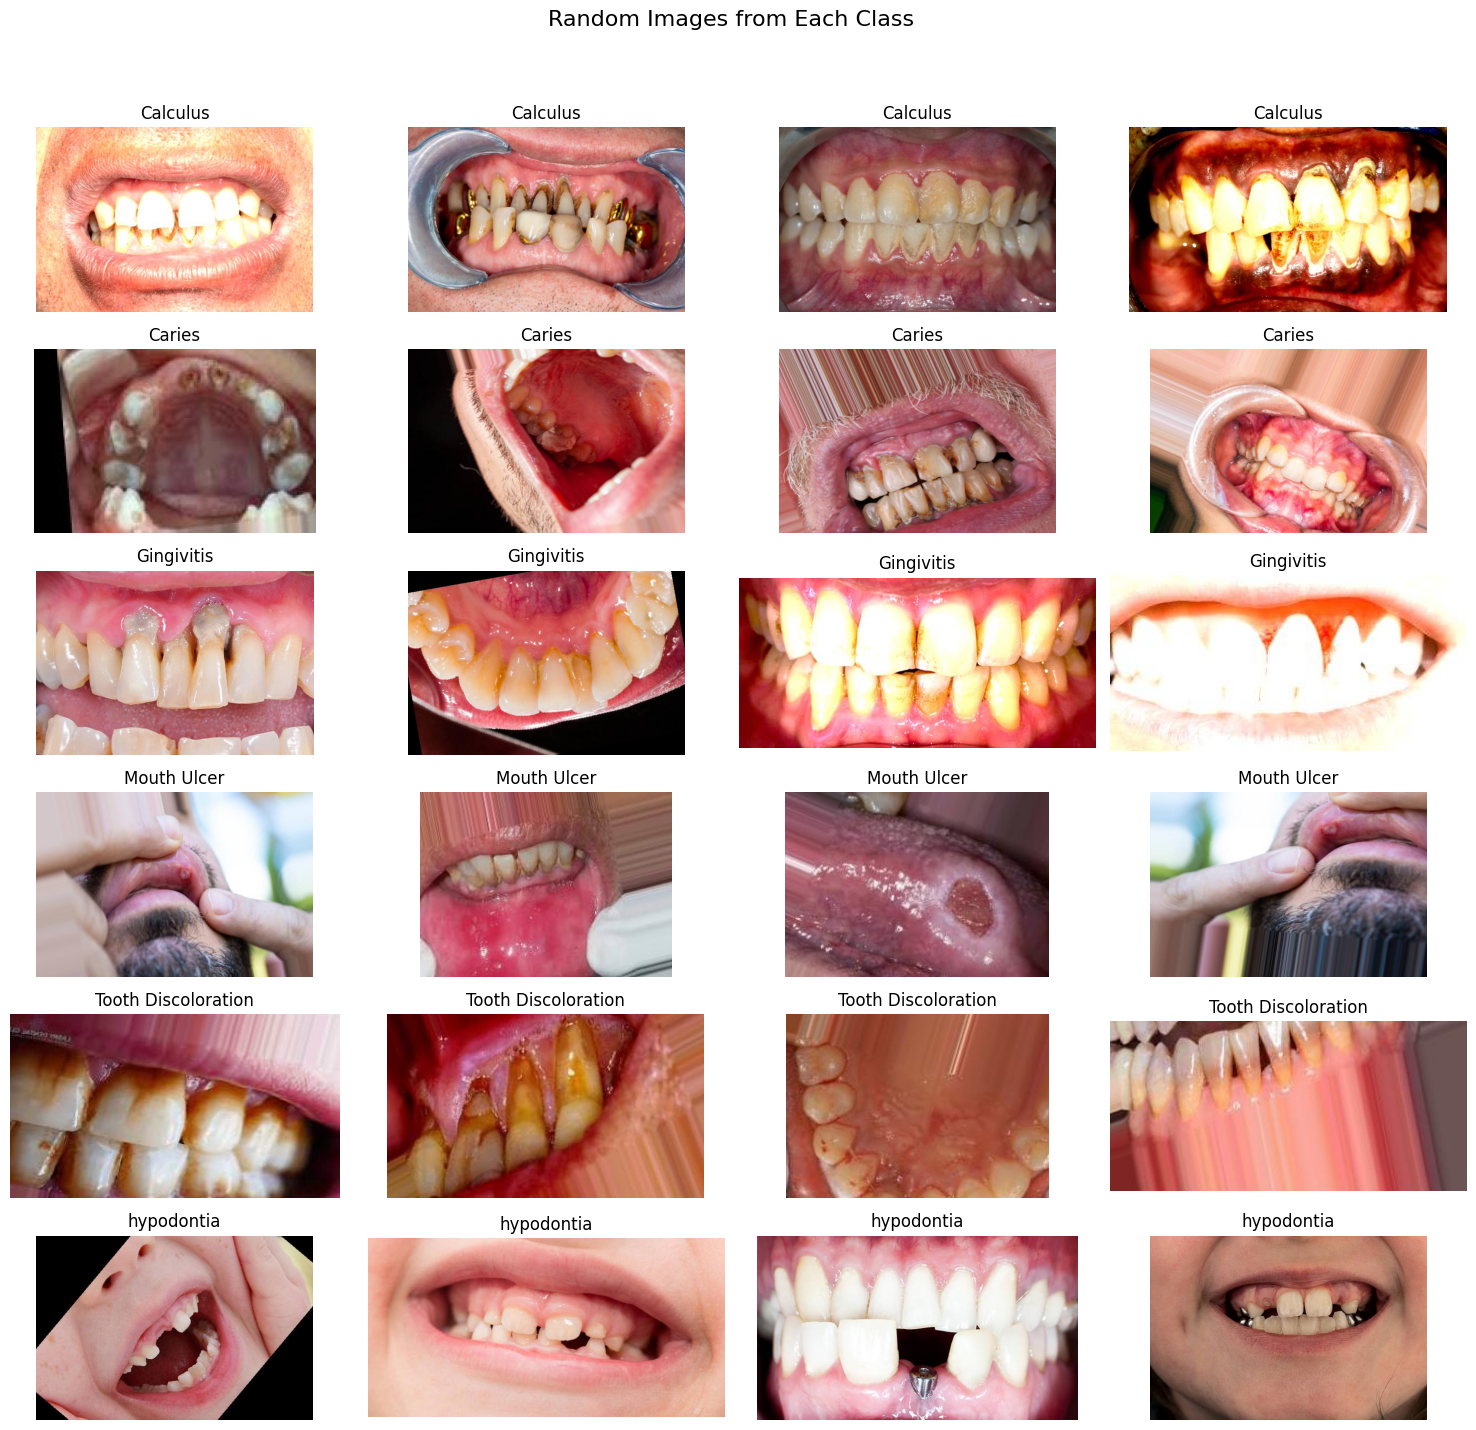

In [7]:
# Number of images to display per class and per row
num_images_per_class = 4
num_images_per_row = 4

# Function to fetch random images from a given directory
def get_random_images(directory , num_images):
    """
    Returns a list of random image paths from the given directory.
    Supports jpg, jpeg, and png formats.
    """
    all_images = [os.path.join(directory, image) for image in os.listdir(directory)
                  if image.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) <= num_images:
        return all_images

    return random.sample(all_images,num_images)

# Calculate the number of rows needed for displaying images
total_images = len(classes)*num_images_per_class
num_rows = (total_images + num_images_per_row - 1)// num_images_per_row

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_images_per_row ,figsize = (15,num_rows*2.5) )
fig.suptitle("Random Images from Each Class", fontsize=16)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Keep track of the subplot index
image_index = 0

# Loop through each class and display random images
for class_name in classes:
    class_path = os.path.join(base_dir,'train',class_name)
    random_images = get_random_images(class_path,num_images_per_class)

    for img_path in random_images:
        if image_index <len(axes):
            image = Image.open(img_path)
            axes[image_index].imshow(image)
            axes[image_index].set_title(class_name)
            axes[image_index].axis('off')
            image_index += 1


# Hide any remaining unused subplots
for i in range(image_index, len(axes)):
    axes[i].axis('off')

# Adjust spacing and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

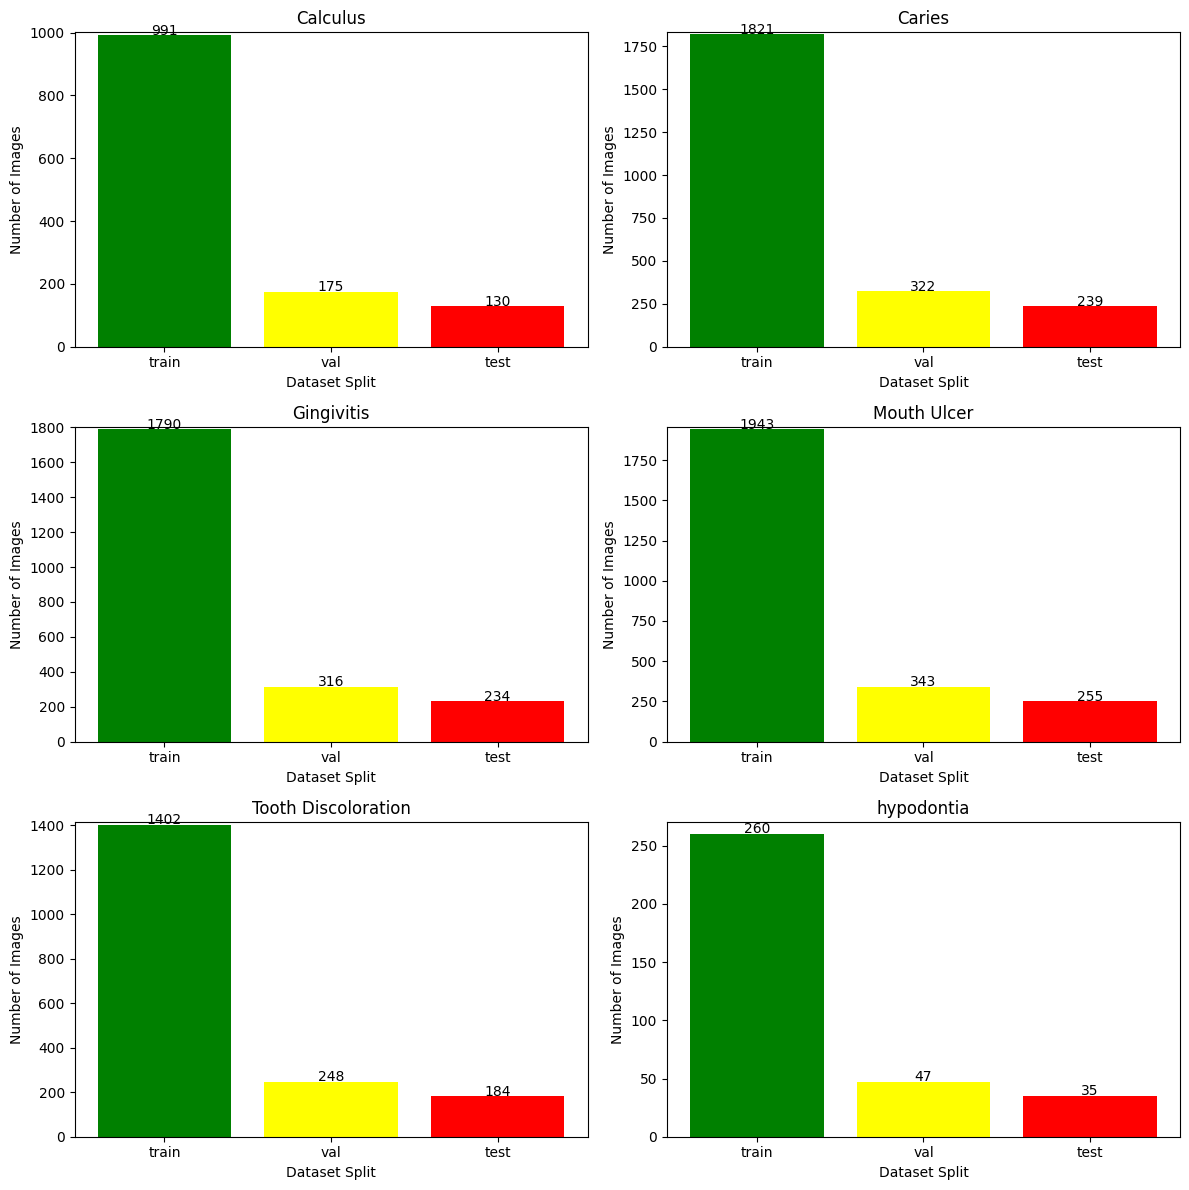

In [8]:
#  Function to count the number of images in each split (train, val, test) for a given class
def count_images(base_dir, class_name):
    counts = {}
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts

# Count images for each class and store results in a dictionary
class_split_counts = {class_name: count_images(base_dir, class_name) for class_name in classes}

# Create subplots: 3 rows × 2 columns (total 6 plots)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easy access

# Loop through the first 6 classes and create bar plots
for idx, class_name in enumerate(classes[:6]):
    counts = class_split_counts[class_name]
    ax = axes[idx]

    # Create a bar chart for this class (Train, Val, Test)
    ax.bar(counts.keys(), counts.values(), color= ['green','yellow','red'])

    # Add titles and labels
    ax.set_title(f"{class_name}", fontsize=12)
    ax.set_xlabel("Dataset Split")
    ax.set_ylabel("Number of Images")
    ax.set_ylim(0, max(counts.values()) + 10)  # Set y-axis limit slightly above max for spacing

    # Display the count values above the bars
    for i, val in enumerate(counts.values()):
        ax.text(i, val + 1, str(val), ha="center", fontsize=10)

# Hide any unused subplots if there are fewer than 6 classes
for j in range(len(classes[:6]), len(axes)):
    axes[j].axis("off")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

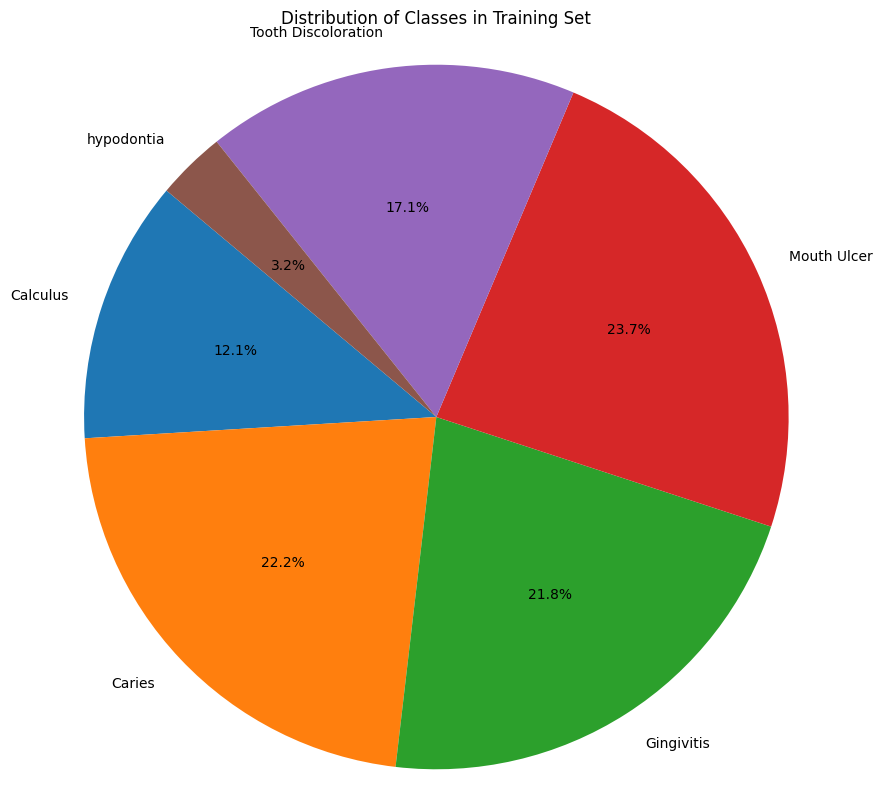

In [9]:
# Create a pie chart showing the distribution of classes in the training set
train_counts = {class_name: counts["train"] for class_name, counts in class_split_counts.items()}

plt.figure(figsize=(10, 10))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Classes in Training Set")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

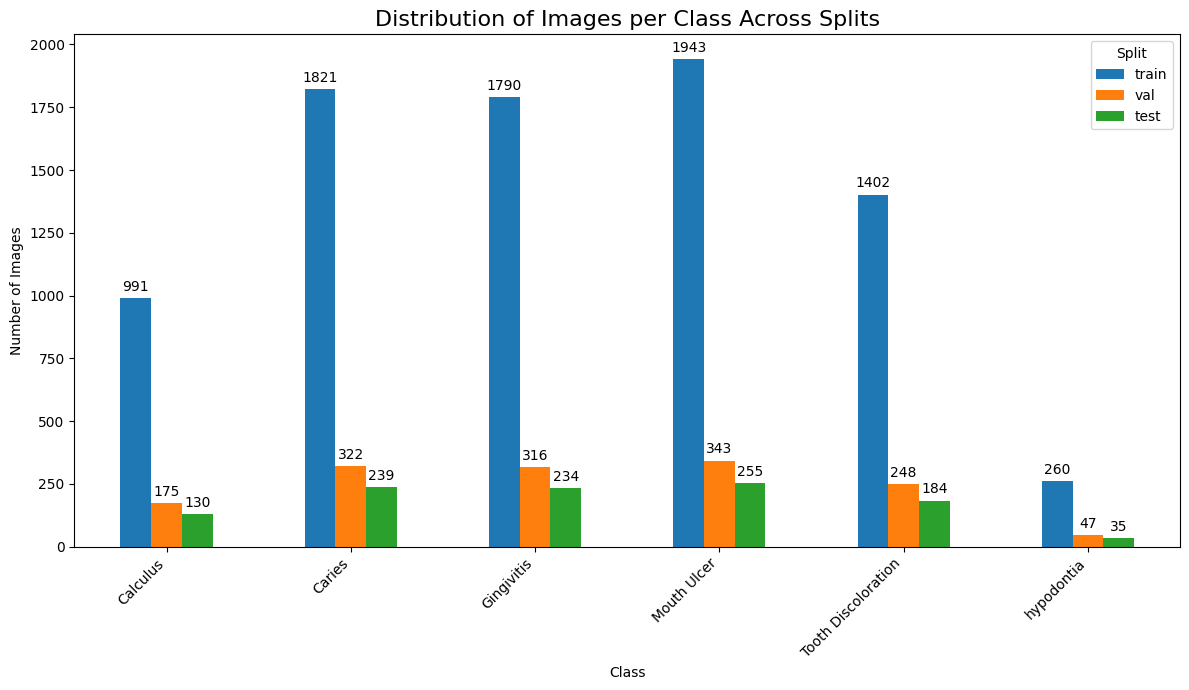

In [10]:
import pandas as pd
# Convert the dictionary to a Pandas DataFrame for easier plotting
df_counts = pd.DataFrame(class_split_counts).T
df_counts = df_counts.sort_index()

# Create a grouped bar chart
ax = df_counts.plot(kind='bar', figsize=(12, 7), rot=0)

# Add titles and labels
plt.title('Distribution of Images per Class Across Splits', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split')
plt.tight_layout()

# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

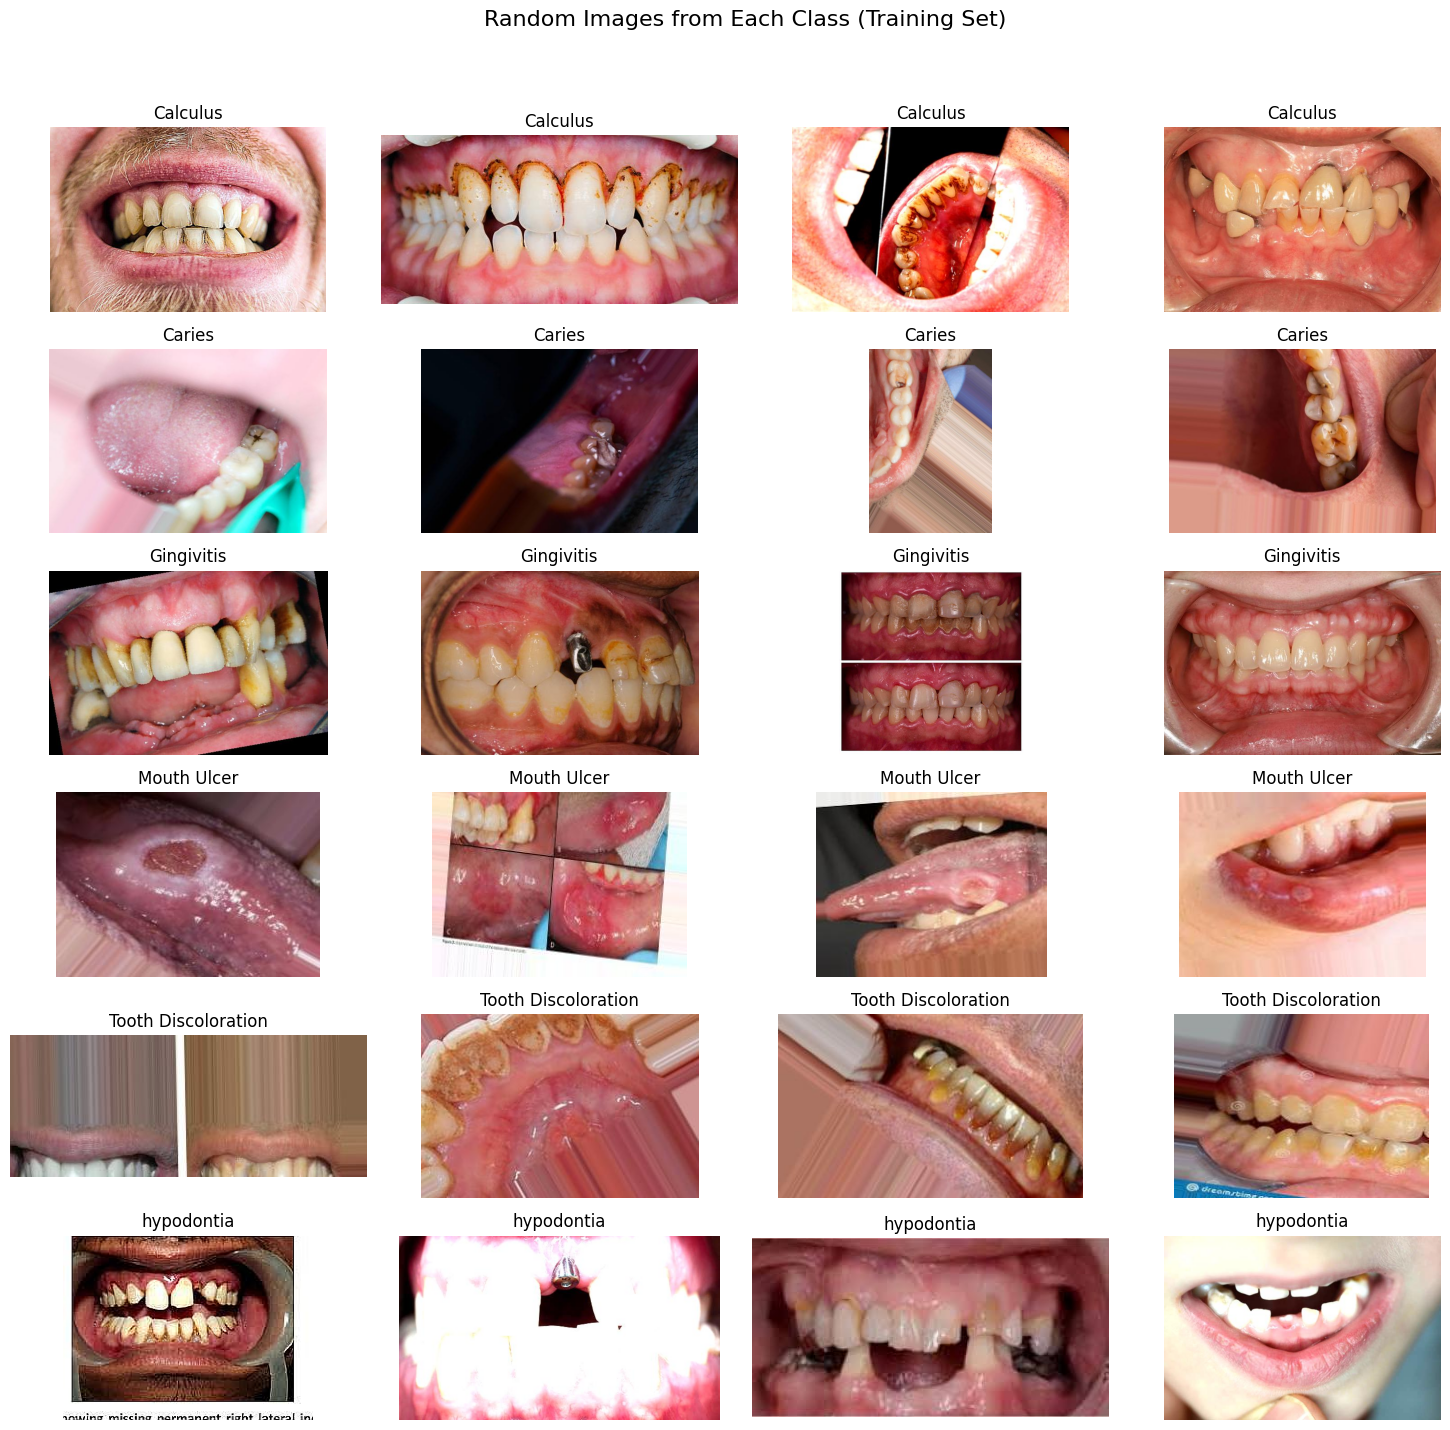

In [11]:
# Function to display random images from each class
def display_random_images_from_classes(base_dir, classes, num_images_per_class=4):
    """
    Displays a grid of random images from each specified class in the training set.
    """
    num_classes = len(classes)
    num_rows = (num_classes * num_images_per_class + num_images_per_row - 1) // num_images_per_row

    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
    fig.suptitle("Random Images from Each Class (Training Set)", fontsize=16)
    axes = axes.flatten()

    img_index = 0
    for class_name in classes:
        class_path = os.path.join(base_dir, 'train', class_name)
        random_images = get_random_images(class_path, num_images_per_class)

        for img_path in random_images:
            if img_index < len(axes):
                image = Image.open(img_path)
                axes[img_index].imshow(image)
                axes[img_index].set_title(class_name)
                axes[img_index].axis('off')
                img_index += 1

    for i in range(img_index, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display random images from the training set
display_random_images_from_classes(base_dir, classes)

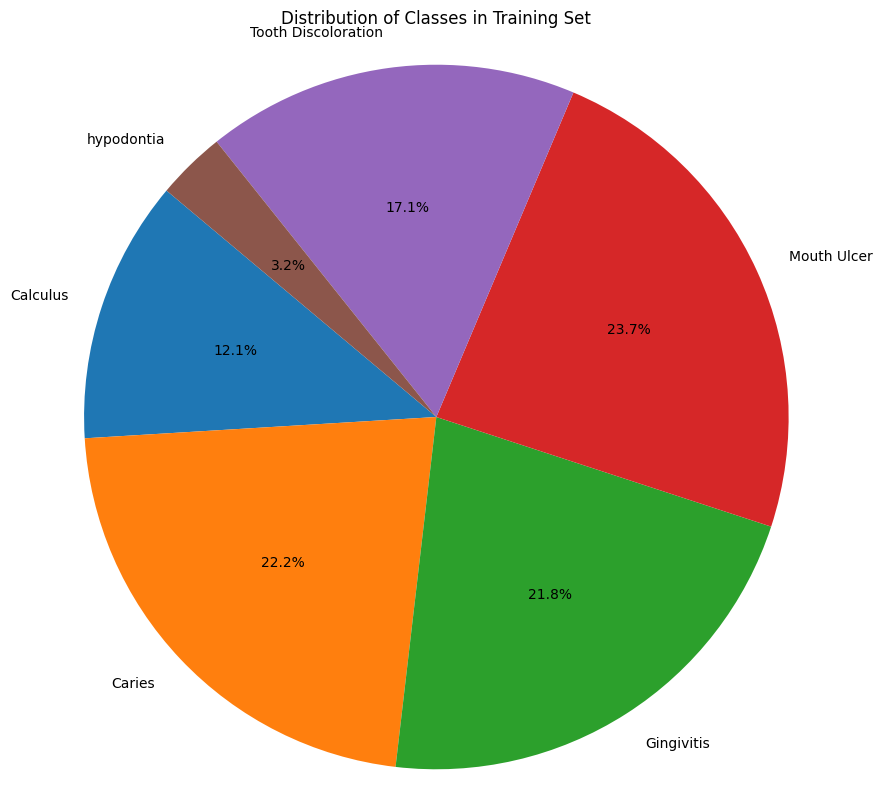

In [12]:
# Create a pie chart showing the distribution of classes in the training set
train_counts = {class_name: counts["train"] for class_name, counts in class_split_counts.items()}

plt.figure(figsize=(10, 10))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Classes in Training Set")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [13]:
#  Function to count the number of images in each split (train, val, test) for a given class
def count_images(base_dir, class_name):
    counts = {}
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts

# Count images for each class and store results in a dictionary
class_split_counts = {class_name: count_images(base_dir, class_name) for class_name in classes}

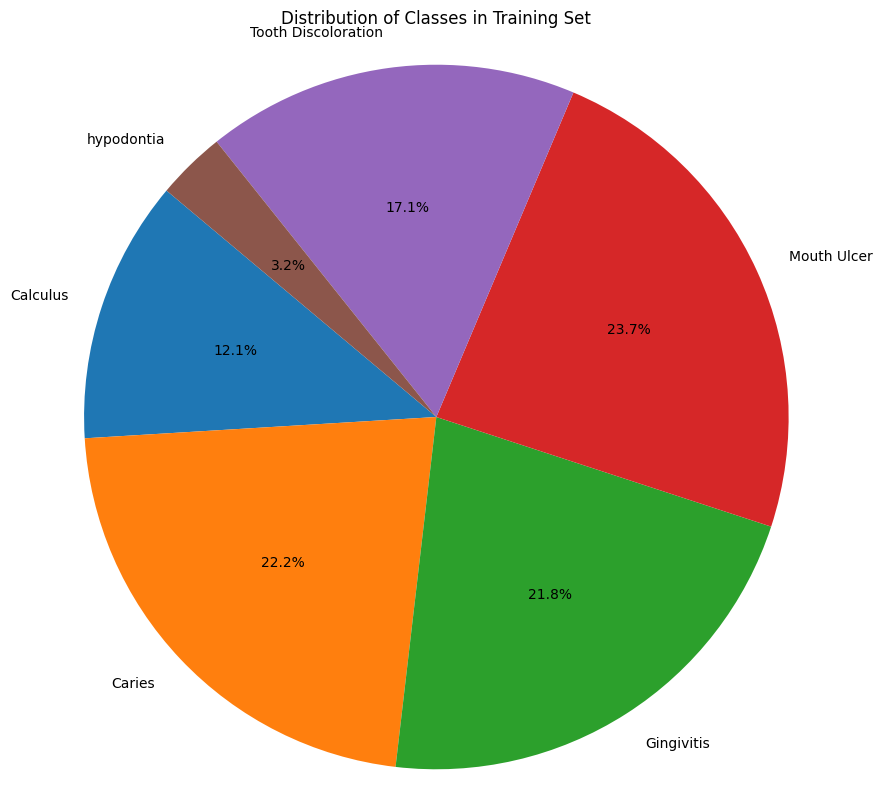

In [14]:
# Create a pie chart showing the distribution of classes in the training set
train_counts = {class_name: counts["train"] for class_name, counts in class_split_counts.items()}

plt.figure(figsize=(10, 10))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Classes in Training Set")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [15]:
# Assuming class_split_counts is already defined from previous steps
# Convert the dictionary to a Pandas DataFrame for easier display as a table
df_counts = pd.DataFrame(class_split_counts).T

# Display the DataFrame as a table
display(df_counts)

train  val  test
Calculus               991  175   130
Caries                1821  322   239
Gingivitis            1790  316   234
Mouth Ulcer           1943  343   255
Tooth Discoloration   1402  248   184
hypodontia             260   47    35

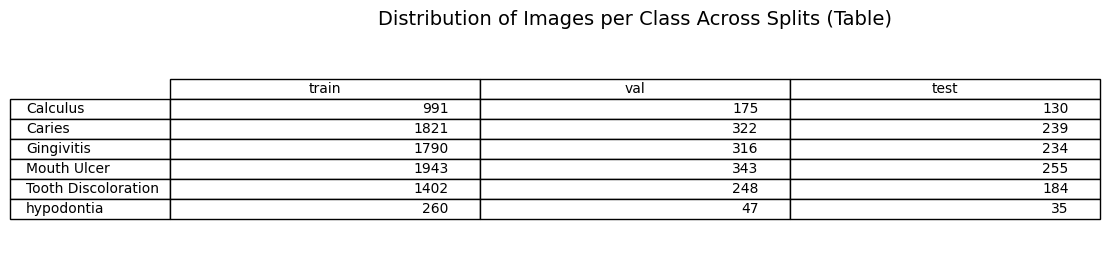

In [16]:
fig, ax = plt.subplots(figsize=(10, 3)) # Adjust figure size as needed
ax.axis('off') # Hide axes
ax.axis('tight') # Adjust layout

# Create the table
table = ax.table(cellText=df_counts.values,
                 colLabels=df_counts.columns,
                 rowLabels=df_counts.index,
                 loc='center')

# Style the table (optional)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) # Adjust scale as needed

plt.title("Distribution of Images per Class Across Splits (Table)", fontsize=14)
plt.show()

In [17]:
# ===========================
# TRAINING TRANSFORMATIONS
# ===========================
train_transforms = A.Compose([
    # Resize and crop to the expected input size for the ViT model (224x224 for ViT-B-16)
    A.RandomResizedCrop(
        size=(224, 224), scale=(0.95, 1.0), p=1.0
    ),

    # Randomly flip the image horizontally or vertically to simulate different viewing angles
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),

    # Slight shift, scaling, and rotation to simulate different head positions
    A.ShiftScaleRotate(
        shift_limit=0.05,      # up to ±5% image shift
        scale_limit=0.05,      # up to ±5% zoom in/out
        rotate_limit=15,        # max ±7 degrees rotation
        border_mode=0,         # fill empty areas with black pixels
        p=0.4
    ),

    # Apply CLAHE to locally enhance image contrast and highlight teeth/gum problems
    A.CLAHE(
        clip_limit=2.5,
        tile_grid_size=(8, 8),
        p=0.4
    ),


    # Normalize image based on ImageNet statistics → suitable for many pretrained models including CLIP
    A.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073], # CLIP ImageNet mean
        std=[0.26862954, 0.26130258, 0.27577711]  # CLIP ImageNet std
    ),

    # Convert image to PyTorch tensor format (C, H, W)
    ToTensorV2(),
], p=1.0)

# ===========================
# VALIDATION TRANSFORMATIONS
# ===========================
val_transforms = A.Compose([
    # Resize and center crop to the expected input size for the ViT model (224x224 for ViT-B-16)
    A.Resize(height=224, width=224),
    A.CenterCrop(height=224, width=224),


    # Normalize using the same CLIP ImageNet statistics as training
    A.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073], # CLIP ImageNet mean
        std=[0.26862954, 0.26130258, 0.27577711]  # CLIP ImageNet std
    ),

    # Convert image to PyTorch tensor format
    ToTensorV2(),
], p=1.0)

# Model Creation

In [18]:
# Custom Dataset to integrate Albumentations
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, classes,transform=None):
        self.image_paths = image_paths
        self.classes = classes
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, label

In [19]:
# Define directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Use ImageFolder to read image paths and labels automatically
train_data = ImageFolder(root=train_dir)
val_data = ImageFolder(root=val_dir)
test_data = ImageFolder(root=test_dir)

classes = train_data.classes

# Extract image paths and labels from ImageFolder
train_image_paths = [path for path, _ in train_data.samples]
train_labels = [label for _, label in train_data.samples]

val_image_paths = [path for path, _ in val_data.samples]
val_labels = [label for _, label in val_data.samples]

test_image_paths = [path for path, _ in test_data.samples]
test_labels = [label for _, label in test_data.samples]

# Create datasets using CustomImageDataset + Albumentations
train_dataset = CustomImageDataset(train_image_paths, train_labels,classes, transform=train_transforms)
val_dataset = CustomImageDataset(val_image_paths, val_labels,classes, transform=val_transforms)
test_dataset = CustomImageDataset(test_image_paths, test_labels,classes, transform=val_transforms)

# Class counts (your data)
class_counts = np.array([991, 1821, 990, 1943, 1402, 260])

# Compute weights for each class
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Map weights to each sample in the training dataset
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
sample_weights = class_weights[train_labels_tensor]

# WeightedRandomSampler to handle class imbalance
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32 , sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [20]:
def show_MRI_batch(dataloader,title = 'Batch of Images'):
    images ,labels = next(iter(dataloader))
    fig , axes = plt.subplots(4,8,figsize = (15,10))
    fig.suptitle(title)
    for i,ax in enumerate(axes.flatten()):
        if i <len(images):
            img = images[i].permute(1,2,0)
            ax.imshow(img)
            ax.set_title(train_dataset.classes[labels[i]])
            ax.axis('off')

    plt.show()

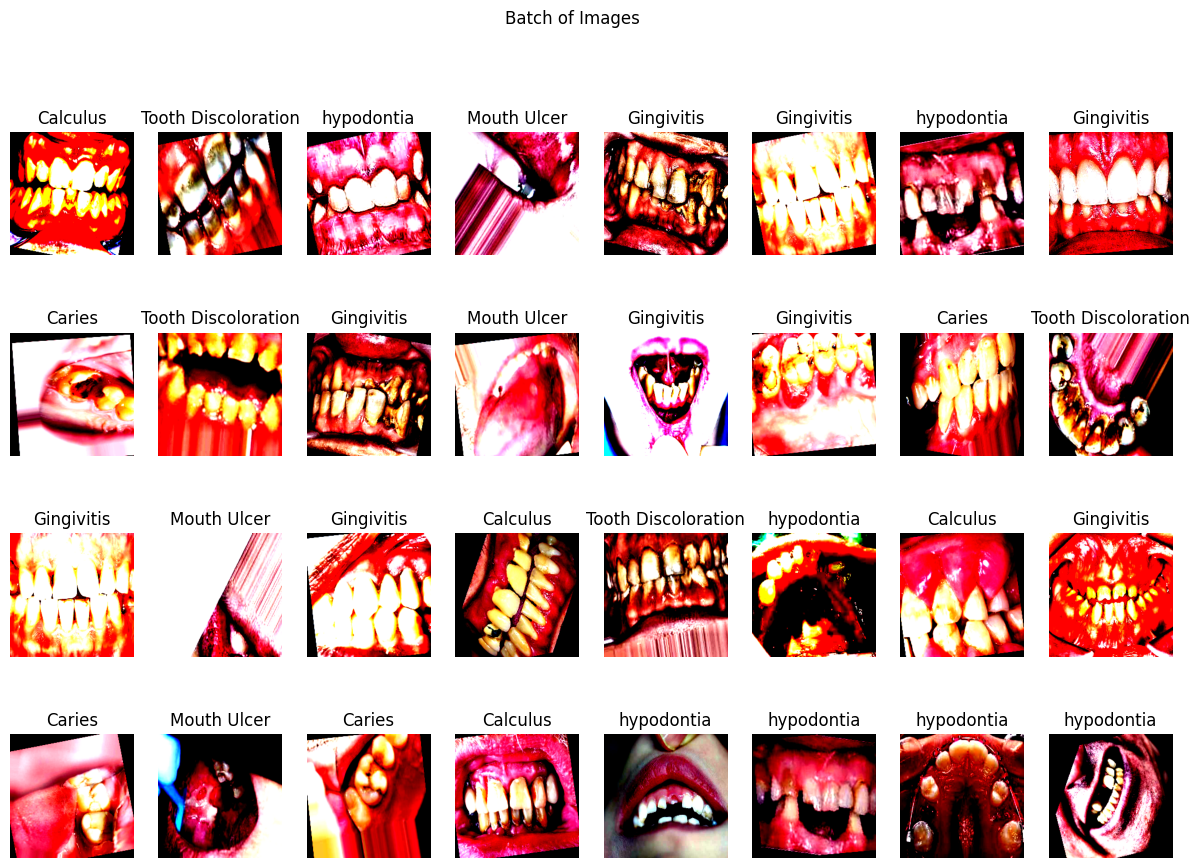

In [21]:
show_MRI_batch(train_loader)

## Training and fitting a model

### A custom efficientnet model

In [22]:
class CustomEfficientnet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientnet,self).__init__()

        # Load pretrained ResNet50
        self.model = timm.create_model('efficientnet_b3',pretrained = True)

        # unFreeze layers
        for param in self.model.parameters():
            param.requires_grad = True

        # Replace the fully connected layer with a custom classifier
        in_features = self.model.classifier.in_features

        self.model.classifier = nn.Sequential(
            nn.Linear(in_features,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,num_classes)
        )

    def forward(self,x):
        return self.model(x)

In [23]:
# Number of images per class (your data)
class_counts = torch.tensor([991, 1821, 990, 1943, 1402, 260], dtype=torch.float)

# Calculate class weights inversely proportional to class frequency
# Formula: weight = total_samples / (num_classes * class_count)
class_weights = 0
class_weights = class_counts.sum() / (len(class_counts) * class_counts)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = class_weights.to(device)

print("Class names:", classes,'\n')
print("Class Weights:", class_weights,'\n')

Class names: ['Calculus', 'Caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia'] 

Class Weights: tensor([1.2457, 0.6779, 1.2470, 0.6354, 0.8805, 4.7481], device='cuda:0') 



In [24]:
num_classes = len(train_dataset.classes)
model = CustomEfficientnet(num_classes)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.00001)
criterion = nn.CrossEntropyLoss(class_weights)
scheduler = ReduceLROnPlateau(optimizer , mode = 'min' , factor = 0.2 , patience = 2)

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [25]:
#%%
num_epochs = 15

scaler = torch.cuda.amp.GradScaler()

best_model_wts = None
best_val_loss = float("inf")

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []


for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)


    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(accuracy)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict().copy()
        torch.save(best_model_wts, "best_model.pth")
        print("✅ Model Saved! Best so far.")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
      f"Train Loss: {avg_train_loss:.4f} | "
      f"Val Loss: {avg_val_loss:.4f} | "
      f"Train Accuracy: {train_accuracy:.2f}% | "
      f"Val Accuracy: {accuracy:.2f}% | "
      f"LR: {optimizer.param_groups[0]['lr']:.8f} |")

100%|██████████| 46/46 [00:05<00:00,  8.30it/s]


✅ Model Saved! Best so far.
Epoch [1/15] Train Loss: 0.6704 | Val Loss: 0.4637 | Train Accuracy: 63.98% | Val Accuracy: 82.15% | LR: 0.00100000 |


100%|██████████| 46/46 [00:04<00:00, 10.25it/s]


Epoch [2/15] Train Loss: 0.3617 | Val Loss: 0.5070 | Train Accuracy: 82.19% | Val Accuracy: 81.39% | LR: 0.00100000 |


100%|██████████| 46/46 [00:04<00:00, 10.30it/s]


✅ Model Saved! Best so far.
Epoch [3/15] Train Loss: 0.3407 | Val Loss: 0.4129 | Train Accuracy: 83.79% | Val Accuracy: 84.36% | LR: 0.00100000 |


100%|██████████| 46/46 [00:05<00:00,  8.74it/s]


✅ Model Saved! Best so far.
Epoch [4/15] Train Loss: 0.2849 | Val Loss: 0.4023 | Train Accuracy: 86.58% | Val Accuracy: 85.80% | LR: 0.00100000 |


100%|██████████| 46/46 [00:05<00:00,  7.97it/s]


Epoch [5/15] Train Loss: 0.2772 | Val Loss: 0.4280 | Train Accuracy: 86.32% | Val Accuracy: 85.53% | LR: 0.00100000 |


100%|██████████| 46/46 [00:04<00:00,  9.98it/s]


✅ Model Saved! Best so far.
Epoch [6/15] Train Loss: 0.2650 | Val Loss: 0.2891 | Train Accuracy: 87.21% | Val Accuracy: 88.15% | LR: 0.00100000 |


100%|██████████| 46/46 [00:04<00:00, 10.14it/s]


Epoch [7/15] Train Loss: 0.2079 | Val Loss: 0.2910 | Train Accuracy: 89.22% | Val Accuracy: 88.35% | LR: 0.00100000 |


100%|██████████| 46/46 [00:05<00:00,  8.37it/s]


Epoch [8/15] Train Loss: 0.2114 | Val Loss: 0.3795 | Train Accuracy: 88.78% | Val Accuracy: 86.35% | LR: 0.00100000 |


100%|██████████| 46/46 [00:04<00:00, 10.09it/s]


Epoch [9/15] Train Loss: 0.2393 | Val Loss: 0.3034 | Train Accuracy: 88.36% | Val Accuracy: 86.22% | LR: 0.00020000 |


100%|██████████| 46/46 [00:04<00:00,  9.69it/s]


✅ Model Saved! Best so far.
Epoch [10/15] Train Loss: 0.1957 | Val Loss: 0.1859 | Train Accuracy: 90.39% | Val Accuracy: 91.39% | LR: 0.00020000 |


100%|██████████| 46/46 [00:04<00:00,  9.82it/s]


✅ Model Saved! Best so far.
Epoch [11/15] Train Loss: 0.1502 | Val Loss: 0.1786 | Train Accuracy: 91.67% | Val Accuracy: 90.70% | LR: 0.00020000 |


100%|██████████| 46/46 [00:05<00:00,  8.14it/s]


✅ Model Saved! Best so far.
Epoch [12/15] Train Loss: 0.1397 | Val Loss: 0.1702 | Train Accuracy: 92.88% | Val Accuracy: 91.32% | LR: 0.00020000 |


100%|██████████| 46/46 [00:04<00:00,  9.84it/s]


✅ Model Saved! Best so far.
Epoch [13/15] Train Loss: 0.1433 | Val Loss: 0.1625 | Train Accuracy: 92.35% | Val Accuracy: 91.87% | LR: 0.00020000 |


100%|██████████| 46/46 [00:04<00:00,  9.92it/s]


Epoch [14/15] Train Loss: 0.1249 | Val Loss: 0.1644 | Train Accuracy: 93.23% | Val Accuracy: 91.80% | LR: 0.00020000 |


100%|██████████| 46/46 [00:05<00:00,  8.53it/s]

Epoch [15/15] Train Loss: 0.1225 | Val Loss: 0.1895 | Train Accuracy: 93.21% | Val Accuracy: 91.11% | LR: 0.00020000 |


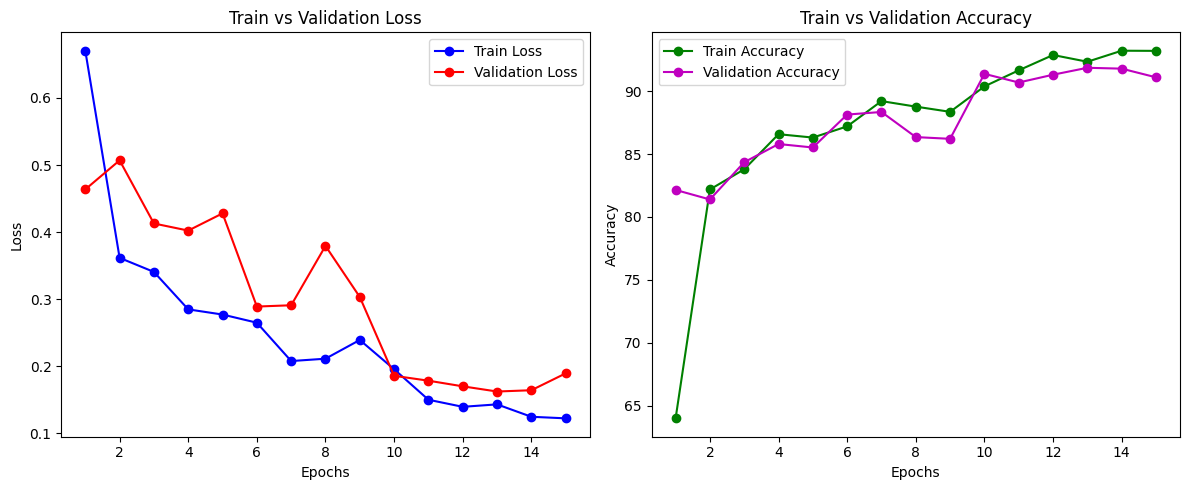

In [26]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list, 'b-o', label='Train Loss')
plt.plot(epochs, val_loss_list , 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(epochs, train_acc_list, 'g-o', label='Train Accuracy')
plt.plot(epochs, val_acc_list, 'm-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

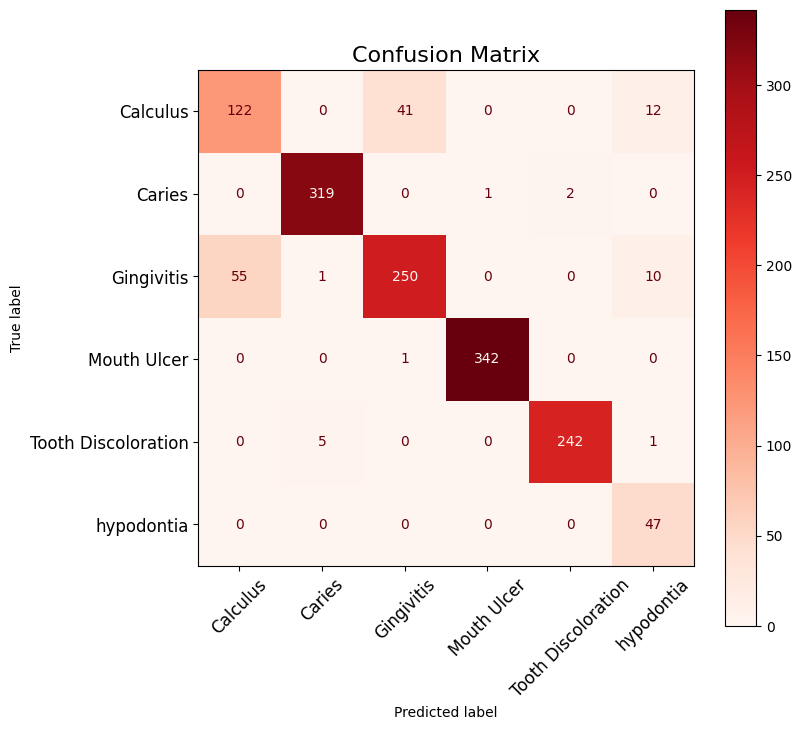

In [27]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix with larger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds")
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
print(classification_report(all_labels, all_predictions, target_names=classes))

                     precision    recall  f1-score   support

           Calculus       0.69      0.70      0.69       175
             Caries       0.98      0.99      0.99       322
         Gingivitis       0.86      0.79      0.82       316
        Mouth Ulcer       1.00      1.00      1.00       343
Tooth Discoloration       0.99      0.98      0.98       248
         hypodontia       0.67      1.00      0.80        47

           accuracy                           0.91      1451
          macro avg       0.86      0.91      0.88      1451
       weighted avg       0.91      0.91      0.91      1451



### Custom Clip model

In [22]:
class CustomCLIPVisionTransformer(nn.Module):
    def __init__(self, num_classes: int, model_name: str = "ViT-B-16", pretrained: str = "openai"):
        super(CustomCLIPVisionTransformer, self).__init__()

        # 1️⃣ Load pretrained CLIP model (ViT backbone only)
        self.clip_model, _, _ = open_clip.create_model_and_transforms(
            model_name,
            pretrained=pretrained
        )
        self.visual_encoder = self.clip_model.visual  # ViT visual encoder

        # 2️⃣ Unfreeze for fine-tuning
        for param in self.visual_encoder.parameters():
            param.requires_grad = True

        # 3️⃣ Get CLIP ViT embedding dimensions
        # The visual encoder's output_dim is the dimension of the pooled feature
        self.embed_dim = self.visual_encoder.output_dim  # e.g. 512 or 768

        # Removed additional self-attention layer as it requires patch tokens
        # and accessing them directly from open_clip's ViT is proving difficult.
        # We will use the standard pooled feature from the visual encoder.

        # 4️⃣ Classification head — flexible MLP
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Removed attn_maps as we are not explicitly capturing attention weights in this simplified version.
        # If attention visualization is needed, a more advanced approach with hooks would be required.


    def forward(self, x):
        """
        x: [B, 3, H, W]
        returns: logits for num_classes
        """
        # Use the standard forward pass of the visual encoder
        # open_clip's VisionTransformer forward method typically returns the pooled output (CLS token feature)
        pooled_features = self.visual_encoder(x) # Shape [B, embed_dim]

        # Pass the pooled features through the classification MLP
        logits = self.classifier(pooled_features)

        # Return logits
        return logits

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)
model = CustomCLIPVisionTransformer(num_classes=num_classes, model_name="ViT-B-16", pretrained="openai").to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)

open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [24]:
#%%
num_epochs = 15

scaler = torch.cuda.amp.GradScaler()

best_model_wts = None
best_val_loss = float("inf")

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []


for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)


    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(accuracy)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict().copy()
        torch.save(best_model_wts, "best_model_clip.pth")
        print("✅ Model Saved! Best so far.")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
      f"Train Loss: {avg_train_loss:.4f} | "
      f"Val Loss: {avg_val_loss:.4f} | "
      f"Train Accuracy: {train_accuracy:.2f}% | "
      f"Val Accuracy: {accuracy:.2f}% | "
      f"LR: {optimizer.param_groups[0]['lr']:.8f} |")

100%|██████████| 46/46 [00:15<00:00,  2.99it/s]


✅ Model Saved! Best so far.
Epoch [1/15] Train Loss: 1.2397 | Val Loss: 1.4990 | Train Accuracy: 49.96% | Val Accuracy: 44.31% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.96it/s]


✅ Model Saved! Best so far.
Epoch [2/15] Train Loss: 0.9012 | Val Loss: 1.0341 | Train Accuracy: 64.70% | Val Accuracy: 56.58% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


✅ Model Saved! Best so far.
Epoch [3/15] Train Loss: 0.7583 | Val Loss: 0.9400 | Train Accuracy: 70.16% | Val Accuracy: 62.58% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.88it/s]


✅ Model Saved! Best so far.
Epoch [4/15] Train Loss: 0.6636 | Val Loss: 0.7920 | Train Accuracy: 74.28% | Val Accuracy: 67.33% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


✅ Model Saved! Best so far.
Epoch [5/15] Train Loss: 0.6134 | Val Loss: 0.6247 | Train Accuracy: 75.56% | Val Accuracy: 75.40% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.88it/s]


Epoch [6/15] Train Loss: 0.5869 | Val Loss: 0.7970 | Train Accuracy: 76.19% | Val Accuracy: 69.33% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


✅ Model Saved! Best so far.
Epoch [7/15] Train Loss: 0.5208 | Val Loss: 0.5231 | Train Accuracy: 79.81% | Val Accuracy: 77.26% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


✅ Model Saved! Best so far.
Epoch [8/15] Train Loss: 0.5018 | Val Loss: 0.5117 | Train Accuracy: 80.07% | Val Accuracy: 78.22% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.95it/s]


Epoch [9/15] Train Loss: 0.4341 | Val Loss: 0.6355 | Train Accuracy: 82.83% | Val Accuracy: 72.98% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Epoch [10/15] Train Loss: 0.4522 | Val Loss: 0.8111 | Train Accuracy: 81.99% | Val Accuracy: 69.54% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.92it/s]


Epoch [11/15] Train Loss: 0.4407 | Val Loss: 0.5259 | Train Accuracy: 82.41% | Val Accuracy: 79.19% | LR: 0.00010000 |


100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


Epoch [12/15] Train Loss: 0.4229 | Val Loss: 0.5719 | Train Accuracy: 82.81% | Val Accuracy: 77.74% | LR: 0.00005000 |


100%|██████████| 46/46 [00:15<00:00,  2.90it/s]


✅ Model Saved! Best so far.
Epoch [13/15] Train Loss: 0.3043 | Val Loss: 0.3079 | Train Accuracy: 87.49% | Val Accuracy: 86.49% | LR: 0.00005000 |


100%|██████████| 46/46 [00:15<00:00,  2.94it/s]


Epoch [14/15] Train Loss: 0.2695 | Val Loss: 0.3418 | Train Accuracy: 88.74% | Val Accuracy: 85.18% | LR: 0.00005000 |


100%|██████████| 46/46 [00:15<00:00,  2.94it/s]

Epoch [15/15] Train Loss: 0.2651 | Val Loss: 0.3102 | Train Accuracy: 88.88% | Val Accuracy: 86.77% | LR: 0.00005000 |


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


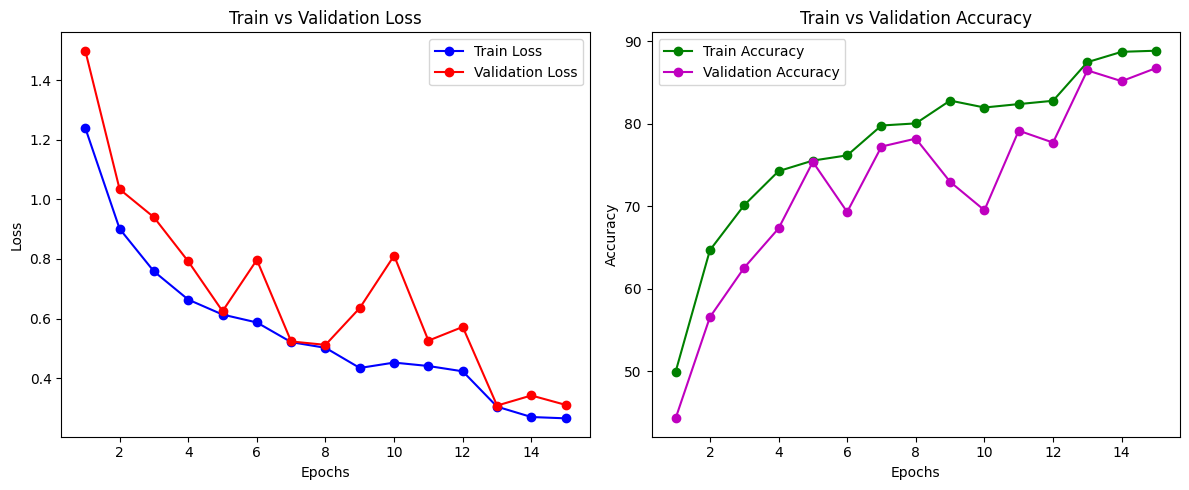

In [25]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list, 'b-o', label='Train Loss')
plt.plot(epochs, val_loss_list , 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(epochs, train_acc_list, 'g-o', label='Train Accuracy')
plt.plot(epochs, val_acc_list, 'm-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

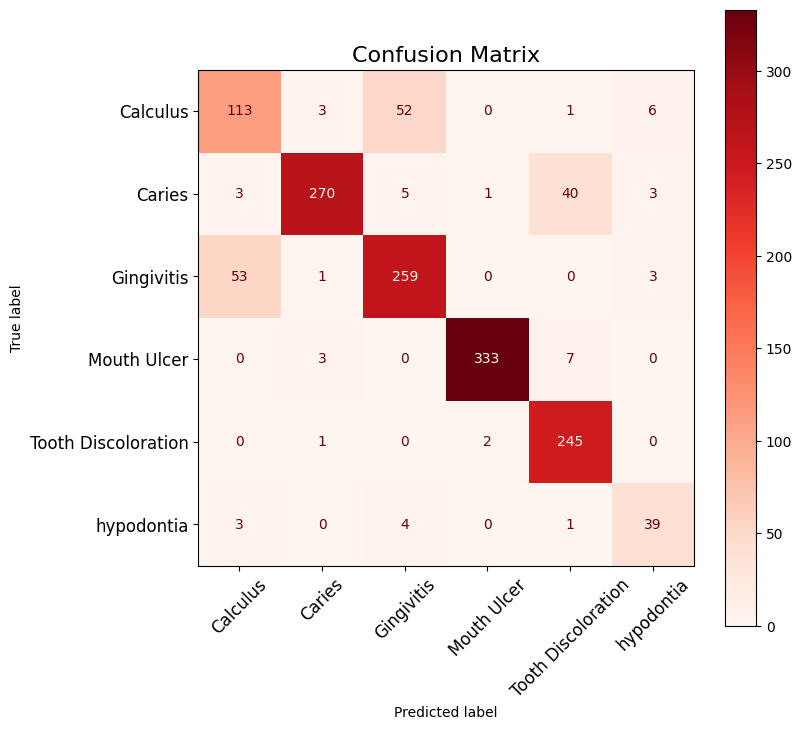

In [26]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix with larger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds")
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [27]:
print(classification_report(all_labels, all_predictions, target_names=classes))

                     precision    recall  f1-score   support

           Calculus       0.66      0.65      0.65       175
             Caries       0.97      0.84      0.90       322
         Gingivitis       0.81      0.82      0.81       316
        Mouth Ulcer       0.99      0.97      0.98       343
Tooth Discoloration       0.83      0.99      0.90       248
         hypodontia       0.76      0.83      0.80        47

           accuracy                           0.87      1451
          macro avg       0.84      0.85      0.84      1451
       weighted avg       0.87      0.87      0.87      1451



### Custom vlm model using clip and bert

In [33]:
class ComplexVLMWithAttention(nn.Module):
    def __init__(self, num_classes: int, model_name: str = "ViT-B-16", pretrained: str = "openai"):
        super(ComplexVLMWithAttention, self).__init__()

        # 1️⃣ Load CLIP visual encoder (ViT backbone)
        self.clip_model, _, _ = open_clip.create_model_and_transforms(
            model_name, pretrained=pretrained
        )
        self.visual_encoder = self.clip_model.visual
        self.embed_dim = self.visual_encoder.output_dim  # e.g., 512 or 768

        # 2️⃣ Load pretrained text encoder (BERT)
        self.text_encoder = BertModel.from_pretrained("bert-base-uncased")
        self.text_dim = self.text_encoder.config.hidden_size  # 768

        # 3️⃣ Cross-Attention Fusion (Image ↔ Text)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=self.embed_dim,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        # 4️⃣ Projection heads
        self.image_proj = nn.Linear(self.embed_dim, 512)
        self.text_proj = nn.Linear(self.text_dim, 512)

        # 5️⃣ Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # 6️⃣ Text tokenizer
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

        # To store attention maps from the ViT
        self.attn_maps = []

    # ========================================
    # IMAGE AND TEXT ENCODERS
    # ========================================

    def encode_image(self, images):
        self.attn_maps = []  # Clear attention maps

        # CORRECTED: Use the standard forward method instead of forward_patch_embed
        # The CLIP ViT handles patch embedding internally
        x = self.visual_encoder(images)

        # For CLIP ViT, we need to use hooks to capture attention maps
        # Register hooks to capture attention from transformer blocks
        def hook_fn(module, input, output):
            # CLIP ViT blocks typically return (output, attention_weights) tuple
            if isinstance(output, tuple) and len(output) == 2:
                self.attn_maps.append(output[1].detach())

        # Register hooks to all transformer blocks
        handles = []
        for block in self.visual_encoder.transformer.resblocks:
            handle = block.register_forward_hook(hook_fn)
            handles.append(handle)

        # Re-run forward pass with hooks
        with torch.no_grad():
            image_features = self.visual_encoder(images)

        # Remove hooks
        for handle in handles:
            handle.remove()

        return image_features

    def encode_text(self, texts):
        tokens = self.tokenizer(
            texts, return_tensors="pt", padding=True, truncation=True, max_length=32
        ).to(next(self.parameters()).device)
        outputs = self.text_encoder(**tokens)
        text_feats = outputs.last_hidden_state[:, 0, :]  # CLS token
        return text_feats

    # ========================================
    # FORWARD PASS
    # ========================================

    def forward(self, images, texts=None):
        image_features = self.encode_image(images)

        if texts is not None:
            text_features = self.encode_text(texts)
            img_proj = self.image_proj(image_features)
            txt_proj = self.text_proj(text_features)

            fused, _ = self.cross_attention(
                img_proj.unsqueeze(1),
                txt_proj.unsqueeze(1),
                txt_proj.unsqueeze(1)
            )
            fused = fused.squeeze(1)

            logits = self.classifier(fused)
            return logits, img_proj, txt_proj, self.attn_maps

        # Inference (no text)
        img_proj = self.image_proj(image_features)
        logits = self.classifier(img_proj)
        return logits, img_proj, None, self.attn_maps

# ========================================
# VISUALIZATION UTILS
# ========================================

def draw_model_structure(model, input_size=(1, 3, 224, 224)):
    """Draws architecture summary and computation graph."""
    print("\n📊 Model Summary:")
    summary(model, input_size)

    dummy_input = torch.randn(input_size)
    y = model(dummy_input)
    # Handle potential multiple outputs from VLM models
    if isinstance(y, tuple):
        output_tensor = y[0] # Use the logits for visualization graph
    else:
        output_tensor = y
    dot = make_dot(output_tensor, params=dict(model.named_parameters()))
    dot.render("vlm_architecture", format="png")
    print("✅ Model structure diagram saved as 'vlm_architecture.png'.")


def visualize_attention_map(model, image_tensor):
    """Draws attention heatmap overlay for a given image."""
    # Use the last attention map (most semantically rich)
    if not model.attn_maps:
        print("⚠️ No attention maps recorded. Run a forward pass first.")
        return

    attn_map = model.attn_maps[-1]  # [Heads, Tokens, Tokens] (assuming batch_first=False or getting one item from batch)
    # Assuming batch_first=True now, so [B, Heads, Tokens, Tokens]
    if attn_map.ndim == 4:
         attn_map = attn_map[0] # Get the first image in the batch

    avg_attn = attn_map.mean(0)[0, 1:]  # average across heads, exclude CLS token (index 0), get attention to patches (index 1 onwards)
    num_patches = avg_attn.shape[0]
    patch_side = int(num_patches ** 0.5)

    if patch_side * patch_side != num_patches:
         print("Warning: Cannot reshape attention tokens into a square grid.")
         return

    heatmap = avg_attn.reshape(patch_side, patch_side).cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8) # Normalize

    # Convert image tensor back to image
    # Ensure image tensor is in the correct format (C, H, W) and denormalized if necessary
    img = image_tensor.squeeze().cpu()
    if img.min() < 0: # Simple check for potential normalization
        # Assuming ImageNet normalization, reverse it
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
    img = T.ToPILImage()(img.clamp(0, 1)) # Clamp to [0, 1] before converting

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.title("Attention Heatmap Overlay")
    plt.show()

🚀 Starting training with ComplexVLMWithAttention model...
📊 Number of classes: 6
🎯 Model handles image resizing internally


Epoch 1/15 [Val]: 100%|██████████| 46/46 [00:31<00:00,  1.44it/s]


✅ Model Saved! Best validation loss so far.
Epoch [1/15] Train Loss: 0.9847 | Val Loss: 0.6412 | Train Accuracy: 63.42% | Val Accuracy: 76.43% | LR: 0.00010000


Epoch 2/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s]


✅ Model Saved! Best validation loss so far.
Epoch [2/15] Train Loss: 0.6266 | Val Loss: 0.5026 | Train Accuracy: 77.01% | Val Accuracy: 80.15% | LR: 0.00010000


Epoch 3/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.50it/s]


✅ Model Saved! Best validation loss so far.
Epoch [3/15] Train Loss: 0.5411 | Val Loss: 0.4530 | Train Accuracy: 79.69% | Val Accuracy: 81.19% | LR: 0.00010000


Epoch 4/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s]


✅ Model Saved! Best validation loss so far.
Epoch [4/15] Train Loss: 0.4930 | Val Loss: 0.4142 | Train Accuracy: 80.87% | Val Accuracy: 83.39% | LR: 0.00010000


Epoch 5/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s]


✅ Model Saved! Best validation loss so far.
Epoch [5/15] Train Loss: 0.4637 | Val Loss: 0.3957 | Train Accuracy: 82.13% | Val Accuracy: 83.05% | LR: 0.00010000


Epoch 6/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.50it/s]


✅ Model Saved! Best validation loss so far.
Epoch [6/15] Train Loss: 0.4424 | Val Loss: 0.3656 | Train Accuracy: 82.49% | Val Accuracy: 84.77% | LR: 0.00010000


Epoch 7/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.50it/s]


✅ Model Saved! Best validation loss so far.
Epoch [7/15] Train Loss: 0.4144 | Val Loss: 0.3542 | Train Accuracy: 83.39% | Val Accuracy: 84.42% | LR: 0.00010000


Epoch 8/15 [Val]: 100%|██████████| 46/46 [00:31<00:00,  1.47it/s]


✅ Model Saved! Best validation loss so far.
Epoch [8/15] Train Loss: 0.3919 | Val Loss: 0.3438 | Train Accuracy: 84.35% | Val Accuracy: 85.25% | LR: 0.00010000


Epoch 9/15 [Val]: 100%|██████████| 46/46 [00:31<00:00,  1.46it/s]


✅ Model Saved! Best validation loss so far.
Epoch [9/15] Train Loss: 0.3732 | Val Loss: 0.3428 | Train Accuracy: 84.53% | Val Accuracy: 84.70% | LR: 0.00010000


Epoch 10/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.51it/s]


Epoch [10/15] Train Loss: 0.3708 | Val Loss: 0.3520 | Train Accuracy: 85.06% | Val Accuracy: 84.36% | LR: 0.00010000


Epoch 11/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s]


✅ Model Saved! Best validation loss so far.
Epoch [11/15] Train Loss: 0.3554 | Val Loss: 0.3098 | Train Accuracy: 85.51% | Val Accuracy: 86.49% | LR: 0.00010000


Epoch 12/15 [Val]: 100%|██████████| 46/46 [00:29<00:00,  1.54it/s]


✅ Model Saved! Best validation loss so far.
Epoch [12/15] Train Loss: 0.3421 | Val Loss: 0.3060 | Train Accuracy: 86.21% | Val Accuracy: 86.84% | LR: 0.00010000


Epoch 13/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.53it/s]


✅ Model Saved! Best validation loss so far.
Epoch [13/15] Train Loss: 0.3366 | Val Loss: 0.2995 | Train Accuracy: 86.09% | Val Accuracy: 87.11% | LR: 0.00010000


Epoch 14/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.52it/s]


✅ Model Saved! Best validation loss so far.
Epoch [14/15] Train Loss: 0.3269 | Val Loss: 0.2982 | Train Accuracy: 86.74% | Val Accuracy: 86.77% | LR: 0.00010000


Epoch 15/15 [Val]: 100%|██████████| 46/46 [00:30<00:00,  1.51it/s]


✅ Model Saved! Best validation loss so far.
Epoch [15/15] Train Loss: 0.3101 | Val Loss: 0.2926 | Train Accuracy: 87.19% | Val Accuracy: 87.59% | LR: 0.00010000
🎉 Training completed!


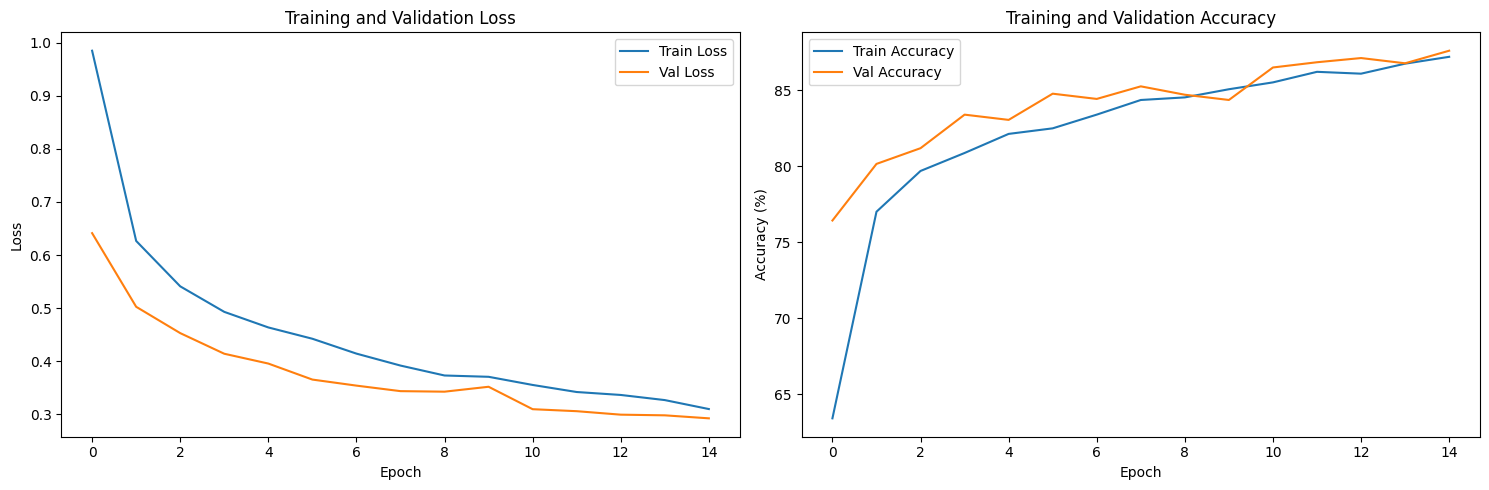

✅ Best model loaded for inference!


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model
num_classes = len(train_dataset.classes)
model = ComplexVLMWithAttention(num_classes=num_classes, model_name="ViT-B-16", pretrained="openai").to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)

# Training loop
num_epochs = 15
scaler = torch.cuda.amp.GradScaler()

best_model_wts = None
best_val_loss = float("inf")

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

print("🚀 Starting training with ComplexVLMWithAttention model...")
print(f"📊 Number of classes: {num_classes}")
print(f"🎯 Model handles image resizing internally")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Model returns (logits, img_proj, txt_proj, attn_maps)
            outputs = model(images)

            # Extract logits from the tuple (first element)
            logits = outputs[0]
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Extract logits from the tuple
            logits = outputs[0]
            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(logits, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(accuracy)

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict().copy()
        torch.save(best_model_wts, "best_model_complex_vlm.pth")
        print("✅ Model Saved! Best validation loss so far.")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Accuracy: {accuracy:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.8f}")

print("🎉 Training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model for inference
model.load_state_dict(torch.load("best_model_complex_vlm.pth"))
print("✅ Best model loaded for inference!")

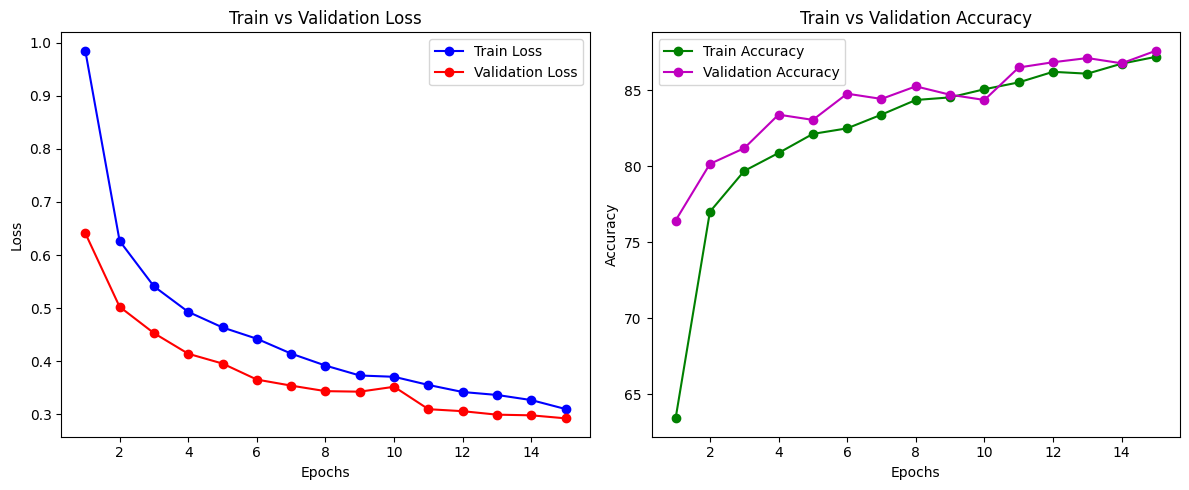

In [35]:
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list, 'b-o', label='Train Loss')
plt.plot(epochs, val_loss_list , 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(epochs, train_acc_list, 'g-o', label='Train Accuracy')
plt.plot(epochs, val_acc_list, 'm-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

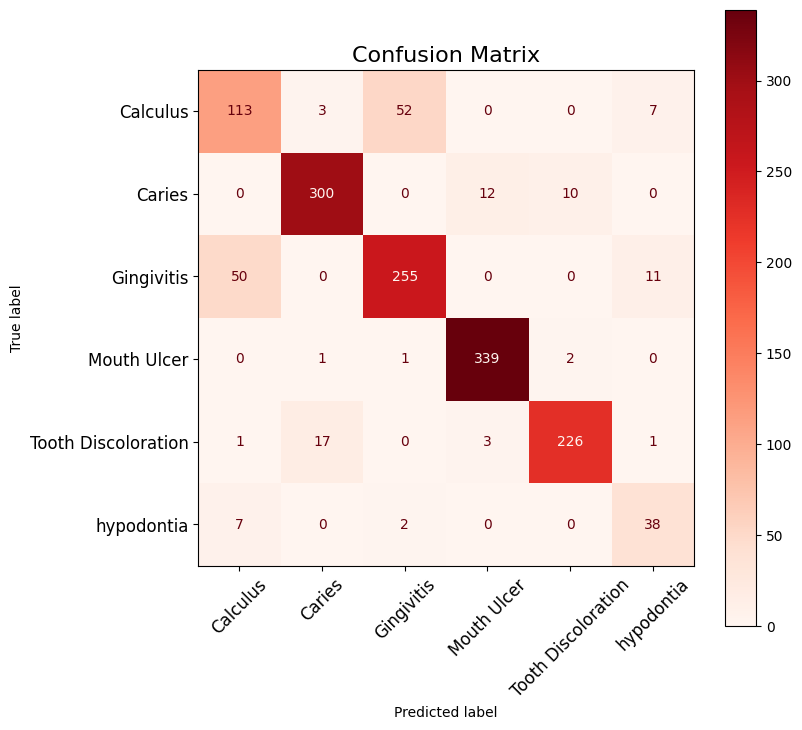

In [36]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix with larger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds")
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [37]:
from sklearn.metrics import classification_report
#
print(classification_report(all_labels, all_predictions, target_names=classes))

                     precision    recall  f1-score   support

           Calculus       0.66      0.65      0.65       175
             Caries       0.93      0.93      0.93       322
         Gingivitis       0.82      0.81      0.81       316
        Mouth Ulcer       0.96      0.99      0.97       343
Tooth Discoloration       0.95      0.91      0.93       248
         hypodontia       0.67      0.81      0.73        47

           accuracy                           0.88      1451
          macro avg       0.83      0.85      0.84      1451
       weighted avg       0.88      0.88      0.88      1451



## Model evaluation

## Evaluating the CNN model

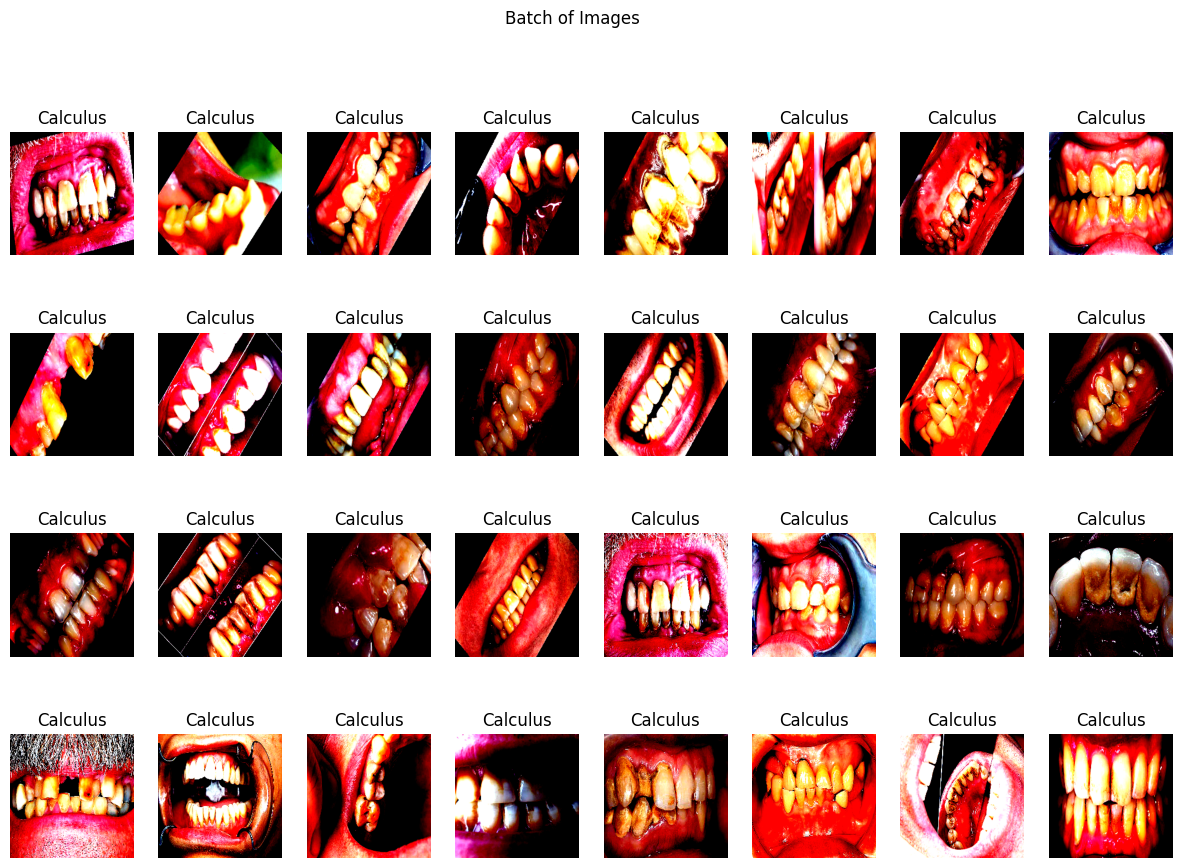

In [38]:
show_MRI_batch(test_loader)

In [39]:
best_model =  CustomEfficientnet(num_classes)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.to(device)
print('best_model ready')

NameError: name 'CustomEfficientnet' is not defined

In [ ]:
best_model.eval()

test_labels = []
test_predictions = []

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Accuracy on Test Set: {accuracy:.2f}%")

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix with larger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds")
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
print(classification_report(test_labels,test_predictions, target_names=classes))

In [ ]:
def visualize_grad_cam(image_paths, model, device, class_names):
    num_images = len(image_paths)
    num_rows = (num_images + 1) // 2
    plt.figure(figsize=(20, 5 * num_rows))

    # EfficientNet من timm: آخر بلوك conv
    target_layer = model.model.blocks[-1]
    grad_cam = GradCAM(model=model, target_layers=[target_layer])

    for idx, image_path in enumerate(image_paths):
        input_image = Image.open(image_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image).unsqueeze(0).to(device)

        grayscale_cam = grad_cam(input_tensor)[0]
        input_image_np = np.array(input_image.resize((224, 224))) / 255.0
        visualization = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
        true_class = os.path.basename(os.path.dirname(image_path))
        title_color = 'green' if true_class == predicted_class else 'red'

        plt.subplot(num_rows, 4, 2 * idx + 1)
        plt.imshow(input_image_np)
        plt.title(f'True: {true_class}', fontsize=24, color=title_color)
        plt.axis('off')

        plt.subplot(num_rows, 4, 2 * idx + 2)
        plt.imshow(visualization)
        plt.title(f'Predicted: {predicted_class}', fontsize=24, color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Get random test images and visualize Grad-CAM
random_images = [os.path.join(test_dir, cls, random.choice(os.listdir(os.path.join(test_dir, cls))))
                 for cls in classes for _ in range(2)]
visualize_grad_cam(random_images, best_model, device, classes)

In [ ]:
# Evaluate the best Custom EfficientNet model on the test set

best_model.eval()

test_labels_clf = []
test_predictions_clf = []

correct_clf = 0
total_clf = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        test_labels_clf.extend(labels.cpu().numpy())
        test_predictions_clf.extend(predicted.cpu().numpy())

        correct_clf += (predicted == labels).sum().item()
        total_clf += labels.size(0)

accuracy_clf = 100 * correct_clf / total_clf
print(f"Accuracy of Custom EfficientNet on Test Set: {accuracy_clf:.2f}%")

# Classification Report
print("\nClassification Report for Custom EfficientNet:")
print(classification_report(test_labels_clf, test_predictions_clf, target_names=classes))

# Confusion Matrix
cm_clf = confusion_matrix(test_labels_clf, test_predictions_clf)
disp_clf = ConfusionMatrixDisplay(confusion_matrix=cm_clf, display_labels=classes)
fig_clf, ax_clf = plt.subplots(figsize=(8, 8))
disp_clf.plot(ax=ax_clf, cmap="Blues")
plt.title("Confusion Matrix for Custom EfficientNet", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Evaluating the clip model

In [40]:
best_model_clip =  CustomCLIPVisionTransformer(num_classes)
best_model_clip.load_state_dict(torch.load("best_model_clip.pth"))
best_model_clip.to(device)
print('best_model clip ready')
print(device)

best_model clip ready
cuda


In [41]:
best_model_clip.eval()

test_labels = []
test_predictions = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = best_model_clip(images)
        _, predicted = torch.max(outputs, 1)

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Accuracy on Test Set: {accuracy:.2f}%")

Accuracy on Test Set: 86.63%


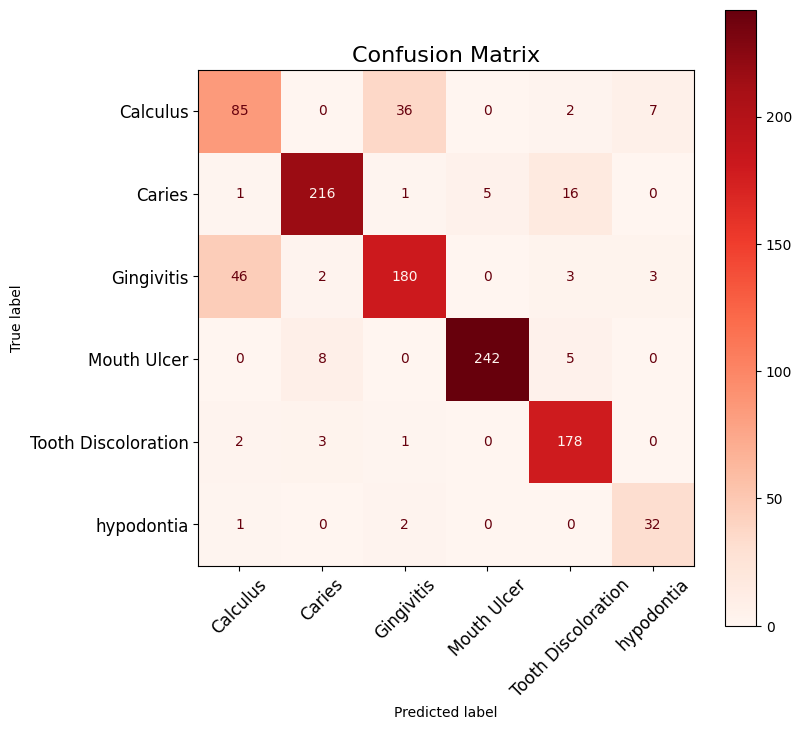

In [42]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix with larger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds")
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
print(classification_report(test_labels,test_predictions, target_names=classes))

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os
import random

def visualize_model_predictions(image_paths, model, device, class_names):
    """
    Universal visualization that works with any model output format
    """
    num_images = len(image_paths)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(20, 5 * num_rows))

    for idx, image_path in enumerate(image_paths):
        try:
            # Load and preprocess image
            input_image = Image.open(image_path).convert('RGB')
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(input_image).unsqueeze(0).to(device)

            # Get prediction - handle different output formats
            with torch.no_grad():
                outputs = model(input_tensor)

                # Handle different output formats
                if isinstance(outputs, tuple):
                    # Tuple format: (logits, img_proj, txt_proj, attn_maps) or similar
                    if len(outputs) >= 1:
                        logits = outputs[0]
                    else:
                        raise ValueError("Empty tuple output")
                else:
                    # Single tensor output
                    logits = outputs

                probabilities = torch.softmax(logits, dim=1)
                _, predicted = torch.max(logits, 1)
                predicted_class = class_names[predicted.item()]
                confidence = probabilities[0, predicted.item()].item()

            # Get true class from path
            true_class = os.path.basename(os.path.dirname(image_path))
            title_color = 'green' if true_class == predicted_class else 'red'

            input_image_np = np.array(input_image.resize((224, 224))) / 255.0

            # Plot image with prediction
            plt.subplot(num_rows, num_cols, idx + 1)
            plt.imshow(input_image_np)

            # Create title with prediction info
            title = f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.3f}'
            plt.title(title, fontsize=10, color=title_color)
            plt.axis('off')

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            # Show error placeholder
            plt.subplot(num_rows, num_cols, idx + 1)
            plt.imshow(np.zeros((224, 224, 3)))
            plt.title(f'Error\n{os.path.basename(image_path)}', fontsize=8, color='red')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

def debug_model_output(image_paths, model, device, class_names):
    """
    Debug function to understand model output format
    """
    print("🔍 Debugging model output format...")

    for i, image_path in enumerate(image_paths[:2]):  # Test first 2 images
        try:
            input_image = Image.open(image_path).convert('RGB')
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(input_image).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(input_tensor)

            print(f"\n📊 Image {i+1}: {os.path.basename(image_path)}")
            print(f"Output type: {type(outputs)}")

            if isinstance(outputs, tuple):
                print(f"Tuple length: {len(outputs)}")
                for j, out in enumerate(outputs):
                    if out is not None:
                        print(f"  Output[{j}]: {type(out).__name__}, shape: {out.shape if hasattr(out, 'shape') else 'N/A'}")
                    else:
                        print(f"  Output[{j}]: None")
            else:
                print(f"Single output shape: {outputs.shape}")

            # Try to get prediction
            if isinstance(outputs, tuple) and len(outputs) > 0:
                logits = outputs[0]
            else:
                logits = outputs

            if hasattr(logits, 'shape'):
                probabilities = torch.softmax(logits, dim=1)
                _, predicted = torch.max(logits, 1)
                predicted_class = class_names[predicted.item()]
                confidence = probabilities[0, predicted.item()].item()
                print(f"Prediction: {predicted_class} (confidence: {confidence:.3f})")

        except Exception as e:
            print(f"Error in debug: {e}")

def visualize_with_gradients(image_paths, model, device, class_names):
    """
    Visualization using gradient-based importance
    """
    num_images = len(image_paths)
    num_cols = 2
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 5 * num_rows))

    for idx, image_path in enumerate(image_paths):
        try:
            # Load and preprocess image
            input_image = Image.open(image_path).convert('RGB')
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(input_image).unsqueeze(0).to(device)
            input_tensor.requires_grad_()

            # Forward pass
            outputs = model(input_tensor)

            # Handle output format
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            probabilities = torch.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            predicted_class = class_names[predicted.item()]
            confidence = probabilities[0, predicted.item()].item()

            # Backward pass for gradients
            model.zero_grad()
            logits[0, predicted.item()].backward()

            # Get gradient importance
            gradients = input_tensor.grad[0].cpu().numpy()
            grad_importance = np.abs(gradients).max(axis=0)  # Max across channels
            grad_importance = (grad_importance - grad_importance.min()) / (grad_importance.max() - grad_importance.min() + 1e-8)

            # Get true class
            true_class = os.path.basename(os.path.dirname(image_path))
            title_color = 'green' if true_class == predicted_class else 'red'

            input_image_np = np.array(input_image.resize((224, 224))) / 255.0

            # Plot original image
            plt.subplot(num_rows, num_cols, 2 * idx + 1)
            plt.imshow(input_image_np)
            plt.title(f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.3f}',
                     fontsize=12, color=title_color)
            plt.axis('off')

            # Plot gradient importance
            plt.subplot(num_rows, num_cols, 2 * idx + 2)
            plt.imshow(input_image_np, alpha=0.7)
            plt.imshow(grad_importance, cmap='hot', alpha=0.5)
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.title('Gradient Importance', fontsize=12)
            plt.axis('off')

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    plt.tight_layout()
    plt.show()

# Test and run functions
def run_comprehensive_visualization():
    # Define your class names
    classes = ['Calculus', 'Caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia']

    # Load your model
    best_model_clip = ComplexVLMWithAttention(num_classes=len(classes))
    best_model_clip.load_state_dict(torch.load("best_model_clip.pth"))
    best_model_clip.to(device)
    best_model_clip.eval()

    # Get test images (1 per class)
    test_dir = "/kaggle/working/dataset/test"
    test_images = []
    for cls in classes:
        cls_dir = os.path.join(test_dir, cls)
        if os.path.exists(cls_dir):
            images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)
                     if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                test_images.append(random.choice(images))

    print(f"Found {len(test_images)} test images")

    if not test_images:
        print("No test images found!")
        return

    # Step 1: Debug model output format
    print("1. Debugging model output format:")
    debug_model_output(test_images, best_model_clip, device, classes)

    # Step 2: Simple predictions
    print("\n2. Simple predictions:")
    visualize_model_predictions(test_images, best_model_clip, device, classes)

    # Step 3: Gradient-based visualization (if model supports gradients)
    print("\n3. Gradient-based visualization:")
    visualize_with_gradients(test_images, best_model_clip, device, classes)

# Simple reliable version
def simple_visualize_predictions(image_paths, model, device, class_names):
    """
    Most reliable visualization - just shows predictions
    """
    num_images = len(image_paths)
    num_cols = min(4, num_images)
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(20, 5 * num_rows))

    for idx, image_path in enumerate(image_paths):
        try:
            # Load image
            input_image = Image.open(image_path).convert('RGB')
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(input_image).unsqueeze(0).to(device)

            # Get prediction
            with torch.no_grad():
                output = model(input_tensor)

                # Handle both tuple and tensor outputs
                if isinstance(output, tuple):
                    logits = output[0]  # First element is logits
                else:
                    logits = output

                probabilities = torch.softmax(logits, dim=1)
                _, predicted = torch.max(logits, 1)
                predicted_class = class_names[predicted.item()]
                confidence = probabilities[0, predicted.item()].item()

            # Get true class
            true_class = os.path.basename(os.path.dirname(image_path))
            title_color = 'green' if true_class == predicted_class else 'red'

            # Display
            plt.subplot(num_rows, num_cols, idx + 1)
            plt.imshow(np.array(input_image.resize((224, 224))) / 255.0)
            plt.title(f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.3f}',
                     fontsize=10, color=title_color)
            plt.axis('off')

        except Exception as e:
            print(f"Error with {os.path.basename(image_path)}: {e}")
            # Show placeholder
            plt.subplot(num_rows, num_cols, idx + 1)
            plt.imshow(np.zeros((224, 224, 3)))
            plt.title(f'Error\n{os.path.basename(image_path)}', fontsize=8, color='red')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the simple reliable version
def run_simple_visualization():
    classes = ['Calculus', 'Caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia']

    # Load model
    best_model_clip = ComplexVLMWithAttention(num_classes=len(classes))
    best_model_clip.load_state_dict(torch.load("best_model_clip.pth"))
    best_model_clip.to(device)
    best_model_clip.eval()

    # Get test images
    test_dir = "/kaggle/working/dataset/test"
    test_images = []
    for cls in classes:
        cls_dir = os.path.join(test_dir, cls)
        if os.path.exists(cls_dir):
            images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)
                     if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                test_images.append(random.choice(images))

    print(f"Visualizing {len(test_images)} images...")
    simple_visualize_predictions(test_images, best_model_clip, device, classes)

# Run the simple version (most reliable)
run_simple_visualization()

## Custom VLM MODEL

In [43]:
best_model =  CustomEfficientnet(num_classes)
best_model.load_state_dict(torch.load("best_model_complex_vlm.pth"))
best_model.to(device)
print('best_model ready')

NameError: name 'CustomEfficientnet' is not defined

In [44]:
best_model.eval()

test_labels = []
test_predictions = []

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Accuracy on Test Set: {accuracy:.2f}%")

NameError: name 'best_model' is not defined

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Display confusion matrix with larger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds")
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
print(classification_report(test_labels,test_predictions, target_names=classes))

# Task 2

## Prepare data for yolo

### Subtask:
Convert the existing image dataset into the format required by YOLO, which includes creating text files with bounding box annotations for each image.


**Reasoning**:
Create the directory structure for the YOLO dataset and then iterate through the existing dataset to copy images and create dummy label files with a single bounding box around the entire image.



In [ ]:
import os
import shutil
from PIL import Image

# Define the base directory for the YOLO dataset
yolo_base_dir = "/kaggle/working/yolo_dataset"

# Define the structure for YOLO data
yolo_data_dirs = {
    'train': os.path.join(yolo_base_dir, 'images', 'train'),
    'val': os.path.join(yolo_base_dir, 'images', 'val'),
    'test': os.path.join(yolo_base_dir, 'images', 'test'),
    'train_labels': os.path.join(yolo_base_dir, 'labels', 'train'),
    'val_labels': os.path.join(yolo_base_dir, 'labels', 'val'),
    'test_labels': os.path.join(yolo_base_dir, 'labels', 'test')
}

# Create the directories
for dir_path in yolo_data_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Function to create a dummy YOLO label file for an image
def create_dummy_label(image_path, label_path, class_id):
    try:
        img = Image.open(image_path)
        width, height = img.size
        # Create a dummy bounding box covering the whole image
        # Format: class_id center_x center_y width height (normalized)
        dummy_bbox = f"{class_id} 0.5 0.5 1.0 1.0"
        with open(label_path, 'w') as f:
            f.write(dummy_bbox)
    except Exception as e:
        print(f"Error creating dummy label for {image_path}: {e}")


# Copy images and create dummy labels
for split in ['train', 'val', 'test']:
    split_image_dir = yolo_data_dirs[split]
    split_label_dir = yolo_data_dirs[f'{split}_labels']

    # Use the original_dirs mapping to get the original paths
    for class_name, original_dir in original_dirs.items():
        # Find the class_id for the current class_name
        class_id = classes.index(class_name)

        # Get image paths from the original directory
        image_paths = [os.path.join(root,file) for root, _ , files in os.walk(original_dir)
                   for file in files if file.endswith(('.jpeg','.jpg','.png'))]

        # Split image paths for the current split (assuming copy_and_transfer_images did the split already)
        # If not, a splitting logic would be needed here based on the original paths
        # For simplicity, I'll assume the files are already in the 'base_dir' structure
        # that was created in the previous steps and use that as the source.
        source_dir = os.path.join(base_dir, split, class_name)
        if os.path.exists(source_dir):
            for image_name in os.listdir(source_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    original_image_path = os.path.join(source_dir, image_name)
                    target_image_path = os.path.join(split_image_dir, image_name)
                    label_name = os.path.splitext(image_name)[0] + '.txt'
                    target_label_path = os.path.join(split_label_dir, label_name)

                    # Copy image
                    shutil.copy(original_image_path, target_image_path)

                    # Create dummy label
                    create_dummy_label(original_image_path, target_label_path, class_id)


print("YOLO dataset structure created and dummy labels generated.")

In [ ]:
# Create the data.yaml file
data_yaml_content = f"""
path: {yolo_base_dir}
train: images/train
val: images/val
test: images/test

nc: {len(classes)}
names: {classes}
"""

with open(os.path.join(yolo_base_dir, 'oral_diseases.yaml'), 'w') as f:
    f.write(data_yaml_content)

print("YOLO configuration file 'oral_diseases.yaml' created.")

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLO model (e.g., yolov8n.pt)
model = YOLO('yolov8n.pt')

# Configure the model for training
# The data argument specifies the path to your dataset configuration file
# The epochs argument sets the number of training epochs
results = model.train(data=os.path.join(yolo_base_dir, 'oral_diseases.yaml'), epochs=25)

## Model Testing and Evaluation

### Evaluate Custom EfficientNet Model

### Evaluate YOLO Model

In [ ]:
# Run inference on a few test images using the fine-tuned YOLO model
# and visualize the predictions with bounding boxes.

# Get a few random image paths from the test set
random_test_image_paths = []
num_images_to_show = 8 # You can adjust this number
for cls in classes:
    class_path = os.path.join(test_dir, cls)
    if os.path.exists(class_path):
        images_in_class = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images_in_class:
            random_test_image_paths.extend(random.sample(images_in_class, min(2, len(images_in_class)))) # Get up to 2 images per class

# Load the best trained YOLO model
# The weights are saved in runs/detect/train/weights/best.pt (or trainX if you ran multiple trainings)
yolo_model_path = '/content/runs/detect/train/weights/best.pt' # Update path if necessary
yolo_model = YOLO(yolo_model_path)

print("\nRunning YOLO inference on sample test images:")
yolo_results = yolo_model(random_test_image_paths)

# Visualize the results
for result in yolo_results:
    # The result object contains the image with predictions drawn on it
    display(Image.fromarray(result.plot()[:,:,::-1]))

In [ ]:
# Evaluate the YOLO model on the test set
print("\nEvaluating YOLO model on the test set:")
yolo_test_results = yolo_model.val()

print("\nYOLO Model Evaluation Metrics on Test Set:")
# The metrics are stored in the 'box' attribute of the results object
display(yolo_test_results.box.map)